### Shape2Diffusion
Spatial and temporal super-resolution

**Unit**
- space nm
- time s

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from skimage.io import imsave
import time

def brownian_motion(nparticles, num_steps, D, dt):
    positions = np.zeros(2)
    trajectory = np.zeros((nparticles, num_steps, 2))
    sigma = np.sqrt(4 * D * dt) 
    for p in range(nparticles):
        dxy = np.random.randn(num_steps,2)*sigma
        positions = np.cumsum(dxy,axis=0)
        trajectory[p] = positions
        #for step in range(num_steps):
        #    theta = np.random.uniform(0, 2 * np.pi)
        #    radius = 2*np.sqrt(np.random.uniform(0, 1) * (sigma**2))
        #    dx = radius * np.cos(theta)
        #    dy = radius * np.sin(theta)
        #    dx = np.random.randn(1) * sigma
        #    dy = np.random.randn(1) * sigma
        #    positions[0] += dx
        #    positions[1] += dy
        #    trajectory[p, step] = positions 
    return trajectory

def mean_square_displacement_naive_implementation(traj):
    len = traj.shape[0]
    msd = np.zeros(len)
    for tau in range(1,len):
        count = 0
        for t in range(0,len-tau):
            msd[tau] += np.sum((traj[t]-traj[t+tau])**2)
            count += 1
        msd[tau] = msd[tau] / count
    return msd

def mean_square_displacement(traj):
    len = traj.shape[0]
    msd = np.zeros(len)
    for t in range(len):
        displacements = np.sum((traj[t:] - traj[:len-t])**2, axis=1)
        msd[t] = np.mean(displacements)
    return msd
    
def show_plt(plt, title, xlabel='', ylabel=''):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    #plt.legend()
    plt.show()

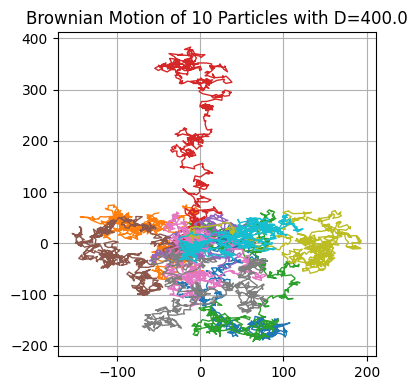

In [2]:
# Generate particle traces
nparticles = 10   # Number of particles
nframes = 100    # Number of steps in the simulation
nposframe = 8    # Number of position per frame
dt = 0.01        # Integration time frame in second
D = 400.0        # Diffusion coefficient per dt
num_steps = nframes*nposframe

trajectory = brownian_motion(nparticles, num_steps, D, dt)

fig = plt.figure(figsize=(4, 4))
for p in range(nparticles):
    plt.plot(trajectory[p, :, 0], trajectory[p, :, 1], lw=1, label=f'{p}')
    
show_plt(plt, f'Brownian Motion of {nparticles} Particles with D={D}')
fig.savefig(f'Brownian Motion {nparticles} particles D{D}.pdf', bbox_inches='tight')

Diffusion on average=743.465
Diffusion N_particles=10 N_step=800 mean=743.465 std=1170.256


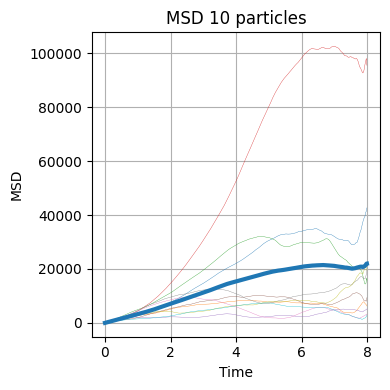

<Figure size 640x480 with 0 Axes>

In [3]:
plt.figure(figsize=(4, 4))
time_range = np.arange(num_steps) * dt
D_estimated = np.zeros(nparticles)
msd = np.zeros((nparticles, num_steps))

for p in range(nparticles):
    msd[p] = mean_square_displacement(trajectory[p, :, :])
    plt.plot(np.arange(num_steps) * dt, msd[p], lw=0.25, label=f'{p}')
    #plt.plot(time, slope * time + intercept, 'k--', lw=0.5 )
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_range, msd[p])
    D_estimated[p] = slope / 4
    #print(i, 'D=', D_estimated[i])

# Average MSD
msd_mean = np.mean(msd, axis=0)
plt.plot(np.arange(num_steps) * dt, msd_mean, lw=3, label=f'Average')
slope, intercept, r_value, p_value, std_err = stats.linregress(time_range, msd_mean)
D_mean_estimated = slope / 4
print(f'Diffusion on average={np.mean(D_mean_estimated):3.3f}')
print(f'Diffusion N_particles={nparticles} N_step={num_steps} mean={np.mean(D_estimated):3.3f} std={np.std(D_estimated):3.3f}')

show_plt(plt, f'MSD {nparticles} particles', 'Time', 'MSD')  
plt.tight_layout()
plt.show()
fig.savefig(f'MSD {nparticles} particles D{D_mean_estimated:3.3f}.pdf', bbox_inches='tight')

In [4]:
# Sampling in time
s = 1
for k in range(3):
    time = np.arange(num_steps//s) * dt
    msd = np.zeros((nparticles, num_steps//s))
    for p in range(nparticles):
        msd[p] = mean_square_displacement(trajectory[p, ::s, :])
    msd_mean = np.mean(msd, axis=0)
    slope, intercept, r_value, p_value, std_err = stats.linregress(time, msd_mean)
    D_est = slope / 4
    print(f'Diffusion on sampling {s} D={np.mean(D_est):3.3f} per {s*dt} = {D_est/(s*dt*1000):3.3f} um/s')
    s = s*2 # Sampling step on the trajectory

Diffusion on sampling 1 D=743.465 per 0.01 = 74.347 um/s
Diffusion on sampling 2 D=1490.401 per 0.02 = 74.520 um/s
Diffusion on sampling 4 D=2983.963 per 0.04 = 74.599 um/s


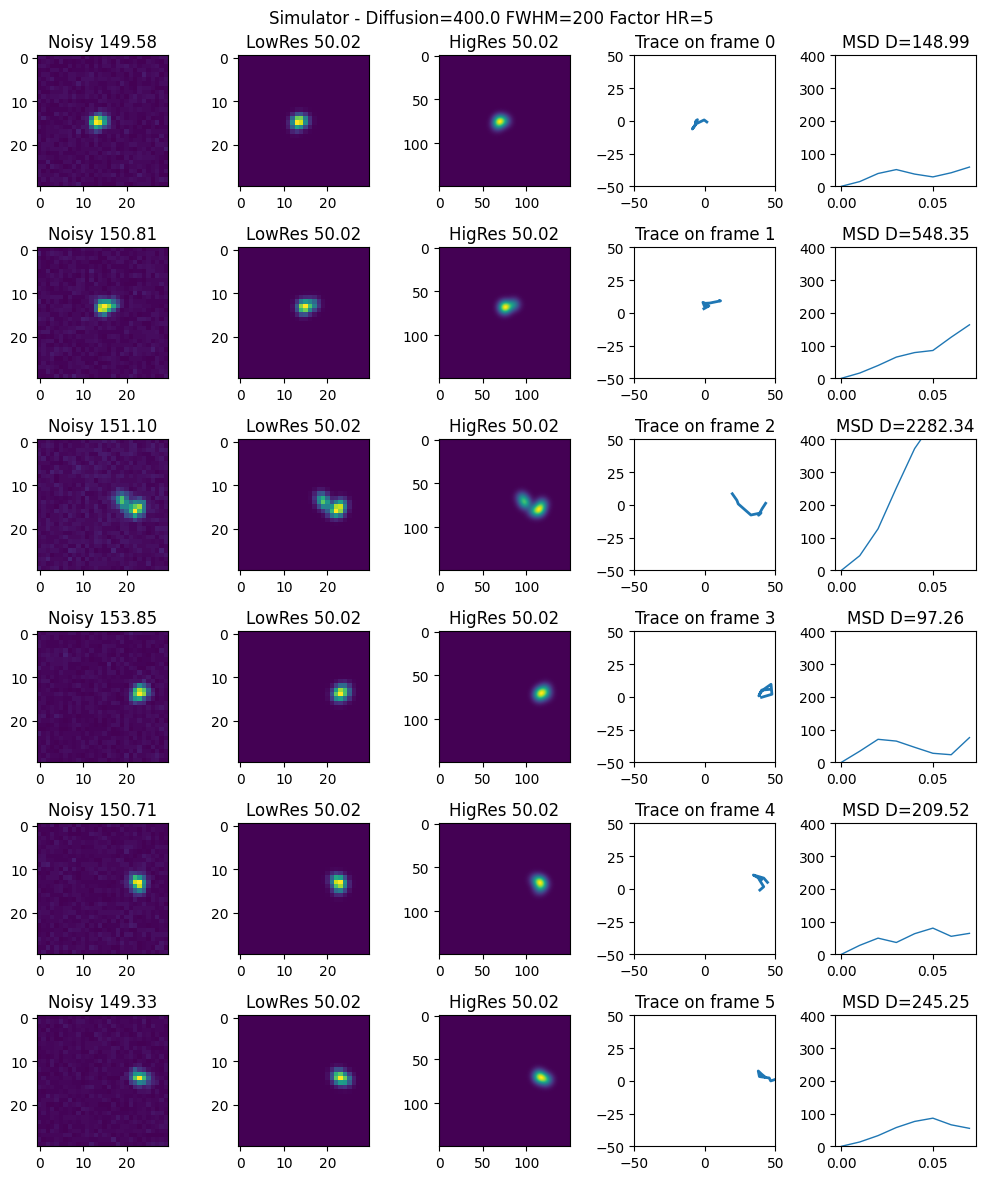

In [5]:
import numpy as np
from skimage.measure import block_reduce
from skimage.util import random_noise

def gaussian_2d(xc, yc, sigma, grid_size, amplitude=1.0):
    limit = (grid_size-1)//2
    x = np.linspace(-limit, limit, grid_size)
    y = np.linspace(-limit, limit, grid_size)
    x, y = np.meshgrid(x, y)
    gauss = amplitude * np.exp(-(((x-xc)**2) / (2 * sigma**2) + ((y-yc)**2) / (2 * sigma**2)))
    return gauss

def add_noise_background(image, background, poisson_noise, gaussian_noise):
    background_image = image + np.clip(np.random.normal(background, gaussian_noise, image.shape), 0, background+3*gaussian_noise)
    maxi = np.max(background_image)
    image_normalized = background_image / maxi
    noisy = maxi * poisson_noise * random_noise(image_normalized/poisson_noise, mode='poisson')
    return noisy.astype(np.uint16)
    
npixel = 30
pixelsize = 100 #nm
fwhm_psf = 200
factor_hr = 5
frame_hr = np.zeros((nframes, npixel*factor_hr, npixel*factor_hr))
frame_noisy = np.zeros((nframes, npixel, npixel))
frame_lr = np.zeros((nframes, npixel, npixel))
poisson_noise = 10
gaussian_noise = 10
particle = 0 # particle 0
fig, axs = plt.subplots(6, 5, figsize=(5*2, 2*6))
for k in range(nframes):
    xtraj = trajectory[particle,k*nposframe:(k+1)*nposframe,0]
    ytraj = trajectory[particle,k*nposframe:(k+1)*nposframe,1]
    npoints = xtraj.shape[0]
    # Generate frame, convolution, resampling, noise
    for p in range(npoints):
        frame_spot = gaussian_2d(xtraj[p], ytraj[p], 2.35*fwhm_psf/pixelsize, npixel*factor_hr, 1000) 
        frame_hr[k] += frame_spot
    frame_lr[k] = block_reduce(frame_hr[k], block_size=factor_hr, func=np.mean)
    frame_noisy[k] = add_noise_background(frame_lr[k], 100, poisson_noise, gaussian_noise)
    # Save frames
    imsave(f'images/HighRes/frame-T{k:03d}.tif', frame_hr[k].astype(np.float32), check_contrast=False)
    imsave(f'images/Frames/frame-P{poisson_noise}-G{gaussian_noise}-T{k:03d}.tif', frame_noisy[k].astype(np.uint16), check_contrast=False)
    
    # Plot
    if k < 6:
        axs[k,0].imshow(frame_noisy[k], cmap='viridis')
        #axs[k,0].axis('off')
        axs[k,0].set_title(f'Noisy {np.mean(frame_noisy[k]):3.2f}')
        axs[k,1].imshow(frame_lr[k], cmap='viridis')
        #axs[k,1].axis('off')
        axs[k,1].set_title(f'LowRes {np.mean(frame_lr[k]):3.2f}')
        axs[k,2].imshow(frame_hr[k], cmap='viridis')
        #axs[k,2].axis('off')
        axs[k,2].set_title(f'HigRes {np.mean(frame_hr[k]):3.2f}')
        #plt.colorbar(shw)
        axs[k,3].plot(xtraj, -ytraj, lw=2, label=f'{k}')
        axs[k,3].set_title(f'Trace on frame {k}')
        #for kk in range(0,k): axs[k,2].plot(trajectory[:, kk, 0], -trajectory[:, kk, 1], lw=0.5, label=f'{kk}')
        axs[k,3].set_xlim(-50, 50)
        axs[k,3].set_ylim(-50, 50)
        msd = mean_square_displacement( trajectory[particle,k*nposframe:(k+1)*nposframe,:])
        time = np.arange(msd.shape[0]) * dt
        slope, intercept, r_value, p_value, std_err = stats.linregress(time, msd)
        D_estimated = slope / 4
        axs[k,4].plot(np.arange(msd.shape[0])*dt, msd, lw=1, label=f'D={D_estimated:3.3}')
        axs[k,4].set_ylim(0, D)
        axs[k,4].set_title(f'MSD D={D_estimated:3.2f}')
plt.suptitle(f'Simulator - Diffusion={D} FWHM={fwhm_psf} Factor HR={factor_hr}')    
plt.tight_layout()
plt.show()
fig.savefig(f'simulator-D{D}-FWHM{fwhm_psf}-hr{factor_hr}.pdf', bbox_inches='tight')

In [ ]:
from skimage import restoration
from skimage.transform import rescale
deconvolved = np.zeros(frame_hr.shape)
psf = gaussian_2d(0, 0, 2.35*fwhm_psf/pixelsize, npixel, 1)
iterations = 50
fig, axs = plt.subplots(6, 5, figsize=(5*2, 2*6))
for k in range(nframes):
    mini = np.min(frame_noisy[k])
    maxi = np.max(frame_noisy[k])
    input_image = (frame_noisy[k].astype(np.float64) - mini) / (1.2 * (maxi-mini))
    image_rescaled = rescale(input_image, factor_hr, order=3, mode='reflect', anti_aliasing=False)
    deconvolved[k] = restoration.richardson_lucy(image_rescaled, psf, num_iter=iterations)
    imsave(f'images/Deconvolved/RL-{iterations}-C{k:03d}.tif', deconvolved[k].astype(np.float32))

    if k < 6:
        xtraj = trajectory[particle,k*nposframe:(k+1)*nposframe,0]
        ytraj = trajectory[particle,k*nposframe:(k+1)*nposframe,1]
        xtraj1 = trajectory[particle,(k+1)*nposframe:(k+2)*nposframe,0]
        ytraj1 = trajectory[particle,(k+1)*nposframe:(k+2)*nposframe,1]
        axs[k,0].imshow(frame_noisy[k], cmap='viridis')
        #axs[k,0].axis('off')
        axs[k,0].set_title(f'Noisy {np.mean(frame_noisy[k]):3.2f}')
        axs[k,2].imshow(deconvolved[k], cmap='viridis')
        #axs[k,2].axis('off')
        axs[k,2].set_title(f'RL {np.mean(deconvolved[k]):3.2f}')
        #plt.colorbar(shw)
        axs[k,1].imshow(frame_hr[k], cmap='viridis')
        #axs[k,1].axis('off')
        axs[k,1].set_title(f'GT {np.mean(frame_lr[k]):3.2f}')
        axs[k,3].plot(xtraj, -ytraj, lw=2, label=f'{k}')
        axs[k,3].plot(xtraj1, -ytraj1, lw=1, label=f'{k}')
        #for kk in range(0,k): axs[k,2].plot(trajectory[:, kk, 0], -trajectory[:, kk, 1], lw=0.5, label=f'{kk}')
        axs[k,3].set_xlim(-50, 50)
        axs[k,3].set_ylim(-50, 50)

        msd = mean_square_distance( trajectory[particle,k*nposframe:(k+1)*nposframe,:])
        time = np.arange(msd.shape[0]) * dt
        slope, intercept, r_value, p_value, std_err = stats.linregress(time, msd)
        D_estimated = slope / 4
        
        axs[k,4].imshow(frame_noisy[k]-frame_noisy[k+1], cmap='viridis')
        axs[k,4].set_title(f'F_{k} - F_{k+1}')
    
plt.suptitle(f'Deconvolution RL={iterations}')  
plt.tight_layout()
plt.show()
fig.savefig(f'Deconvolution RL{iterations}.pdf', bbox_inches='tight')